# Using a Probabilistic Program as a proposal in Gen.jl

## 1. A Dataset with Outliers

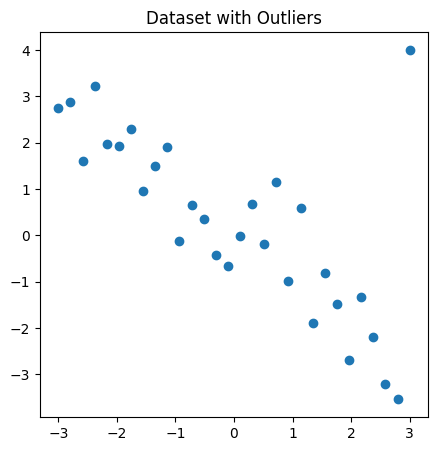

PyObject <matplotlib.text.Text object at 0x32f075750>

In [10]:
using Gen
using Distributions
using PyPlot

# Create Sample Data
srand(40)
xs = collect(linspace(-3, 3, 30))
ys = -xs + randn(length(xs)) * 0.7
ys[end] = 4 # an outlier 

plt[:figure](figsize=(5, 5))
plt[:scatter](xs, ys);
plt[:title]("Dataset with Outliers")

# plt.plot(x, y1, '-b', label='sine')
# pylab.plot(x, y2, '-r', label='cosine')
# pylab.legend(loc='upper left')

## 2. A Gen.jl program for linear regression with outliers

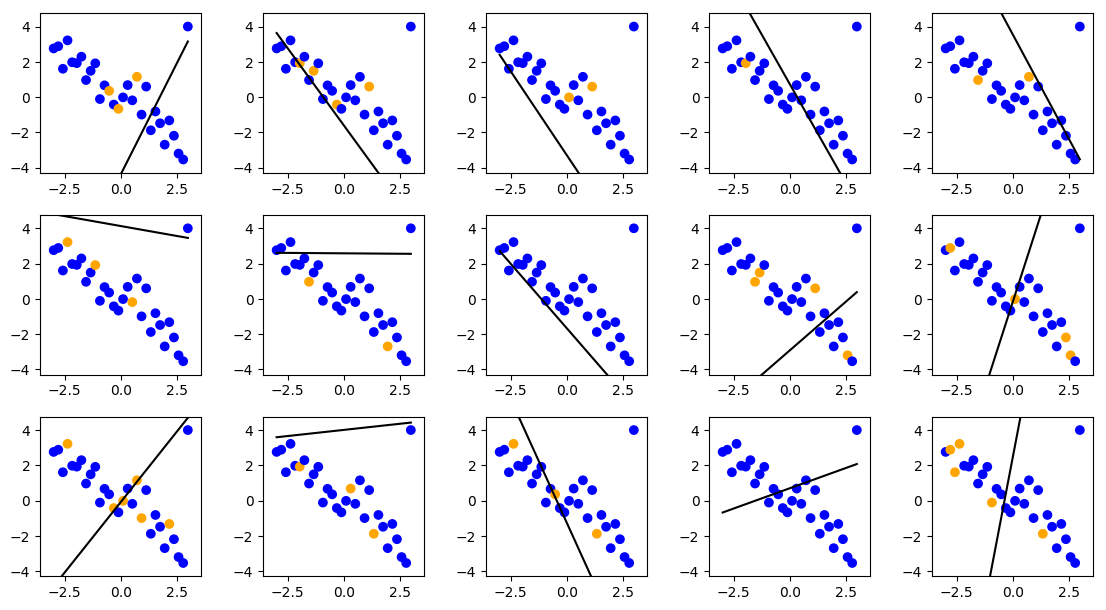

In [11]:
# Linear regression probabilistic model
@program linear_regression_outliers(xs::Array{Float64,1}) begin
    inlier_noise = gamma(1., 1.) ~ "inlier_noise"
    outlier_noise = 10.0
    prob_outlier = 0.1
    slope = normal(0.0, 2.0) ~ "slope"
    intercept = normal(0.0, 2.0) ~ "intercept"
    ys = Array{Float64, 1}(length(xs))
    for i=1:length(xs)
        y_mean = intercept + slope * xs[i]
        noise = (flip(prob_outlier) ~ "o$i") ? outlier_noise : inlier_noise 
        ys[i] = normal(y_mean, noise) ~ "y$i"
    end
end

# Plotting helper function
function render_linreg_trace(trace::Trace, xs::Array{Float64,1})
    ax = plt[:gca]()
    n = length(xs)
    ys = map((i) -> value(trace,"y$i"), 1:n)
    outlier_statuses = map((i) -> value(trace,"o$i"), 1:n)
    slope = value(trace, "slope")
    intercept = value(trace, "intercept")
    xmin, xmax = minimum(xs), maximum(xs)
    xspan = xmax - xmin
    ymin, ymax = minimum(ys), maximum(ys)
    yspan = ymax - ymin
    xlim = [xmin - 0.1 * xspan, xmax + 0.1 * xspan]
    ylim = [ymin - 0.1 * yspan, ymax + 0.1 * yspan]
    colors = map((i) -> outlier_statuses[i] ? "orange" : "blue", 1:n)
    plt[:scatter](xs, ys, c=colors)
    xs_line = [xmin, xmax]
    ys_line = intercept + slope * [xmin, xmax]
    plt[:plot](xs_line, ys_line, color="black")
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
end

plt[:figure](figsize=(11.3, 10))
for i=1:15
    plt[:subplot](5, 5, i)
    ax = plt[:gca]()
    xlim = [-2., 2.]
    ylim = [-2., 2.]
    
    trace = Trace()
    
    for(i, y) in enumerate(ys)
        constrain!(trace, "y$i", y)
    end
    #priors from the generative model
    @generate(trace, linear_regression_outliers(xs))

    render_linreg_trace(trace, xs)
end
plt[:tight_layout]()

## 3. Basic inference with a generic re-simulation proposal

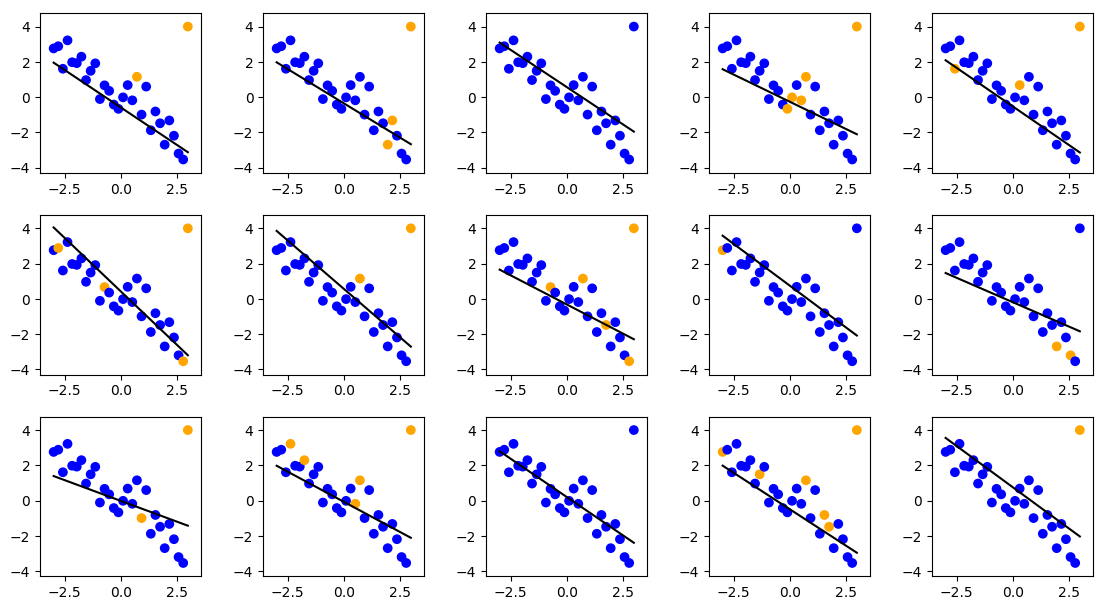

In [18]:
function logsumexp(x::Array{Float64,1})
    maxx = maximum(x)
    maxx + log(sum(exp(x - maxx)))
end

function linear_regression_likelihood_weighting(num_samples::Int, xs::Array{Float64,1}, 
                                               ys::Array{Float64,1})
    scores = Array{Float64,1}(num_samples)
    traces = Array{Trace,1}(num_samples)
    for sample=1:num_samples
        trace = Trace()
        for(i, y) in enumerate(ys)
            constrain!(trace, "y$i", y)
        end
        @generate(trace, linear_regression_outliers(xs))
        traces[sample] = trace
        scores[sample] = score(trace)
    end
    weights = exp(scores - logsumexp(scores))
    chosen = rand(Distributions.Categorical(weights))
    return traces[chosen]
end

# Run inference an unbounded number of times and collects the traces
# function run_inference(xs::Array{Float64,1}, ys::Array{Float64,1}, proposal::Function, proposal_std::Float64, num_samples::Int)
#     traces = []
#     for i=1:num_samples
#         trace = linreg_infer_sir(100, xs, ys, proposal, proposal_std)
#         push!(traces, trace)
#     end
#     traces
# end

traces = []
for replicate=1:15
    trace = Trace()
    num_samples = 1000
    push!(traces, linear_regression_likelihood_weighting(num_samples, xs, ys))
end

plt[:figure](figsize=(11.3, 10))
for (i, trace) in enumerate(traces)
    plt[:subplot](5, 5, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    render_linreg_trace(trace, xs)
end
plt[:tight_layout]()

## 4. A custom proposal program based on RANSAC

RANSAC (Ranson Sample Consensus) is a traditional algorithm for estimating line parameters from observed data. It is known to attribute little (if any) influence on outliers for the estimated parameters. RANSAC iteratively samples two points from the data, estimates a line parameters between them, and scores the parameters according to the number of inliers the line produces on the rest of the data. 

In [19]:
# A basic RANSAC algorithm 

immutable RansacParams

    # the number of random subsets to try
    iters::Int

    # the number of points to use to construct a hypothesis
    subset_size::Int

    # the error threshold below which a datum is considered an inlier
    eps::Float64
end

# The oringal ransac algorithm
function ransac_core(xs::Array{Float64,1}, ys::Array{Float64,1},
                     params::RansacParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    best_inliers = Array{Bool,1}(length(xs))
    for i=1:params.iters

        # select a random subset of points
        ### subset = randperm(length(xs))[1:params.subset_size]
        
        rand_ind = sample(1:length(xs), params.subset_size, replace = false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
    
        ### A = hcat(xs, ones(length(xs)))
        A = hcat(subset_xs, ones(length(subset_xs)))
        
        ### slope, intercept = A\ys
        slope, intercept = A\subset_ys
        
        ypred = intercept + slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_inliers = inliers
            best_num_inliers = num_inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept, best_inliers)
end



ransac_core (generic function with 1 method)

### 4.1 Running RANSAC Directly

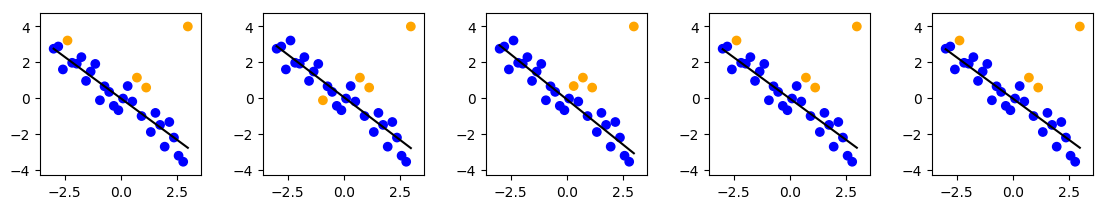

In [32]:
# Run RANSAC with an unbounded number of iterations. Store as traces and return them
function run_ransac(xs::Array{Float64,1}, ys::Array{Float64,1}, num_samples::Int, iterations::Int, ransac::Function)
    traces = []
    for i=1:num_samples
        ransac_params = RansacParams(iterations, 2, 1.)
        slope, intercept, inliers = ransac(xs, ys, ransac_params)
        
        #Just for storing information
        trace = Trace()
        constrain!(trace, "slope", slope)
        constrain!(trace, "intercept", intercept)
        ypred = intercept + slope * xs
        
        for(i, y) in enumerate(ys)
            constrain!(trace, "y$i", y)
        end
        for(i, o) in enumerate(inliers)
            constrain!(trace, "o$i", !o)
        end
        
        push!(traces, trace)
    end
    traces
end

num_samples = 5
traces = run_ransac(xs, ys, num_samples, 1000, ransac_core)

plt[:figure](figsize=(11.3, 10))
for (i, trace) in enumerate(traces)
    plt[:subplot](5, 5, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    
    
    render_linreg_trace(trace, xs)
end
plt[:tight_layout]()

### 4.2 Proposal using RANSAC

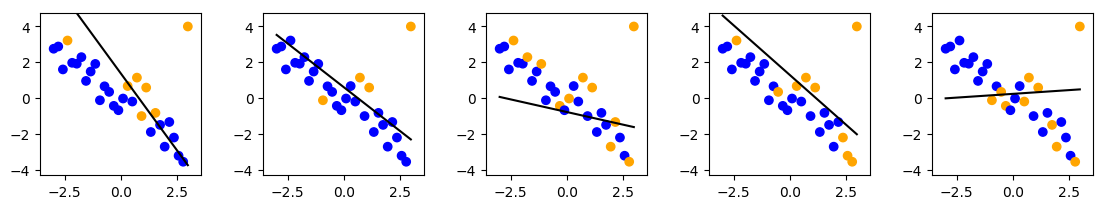

In [45]:
# A proposal program based on RANSAC
@program ransac_proposal(xs::Array{Float64,1},
                         ys::Array{Float64,1},
                         ransac_params::RansacParams, 
                         proposal_std::Float64) begin

    # use RANSAC to guess the line parameters@
    slope, intercept, inliers = ransac_core(xs, ys, ransac_params)

    # add noise to the line parameters
    slope_proposed = normal(slope, proposal_std) ~ "slope"
    intercept_proposed = normal(intercept, proposal_std) ~ "intercept"

    # add some noise to the proposed outlier statuses
    for i=1:length(xs)
        prob_outlier = inliers[i] ? 0.1 : 0.9
        flip(prob_outlier) ~ "o$i"
    end
end

# Run RANSAC with an unbounded number of iterations. Store as traces and return them
function run_ransac_proposal(xs::Array{Float64,1}, ys::Array{Float64,1}, num_samples::Int, ransac::Function)
    traces = []
    for i=1:num_samples
        ransac_params = RansacParams(10, 2, 1.)
        proposal_std = 1.
        trace = Trace()
        @generate(trace, ransac_proposal(xs, ys, ransac_params, proposal_std))
        push!(traces, trace)
    end
    traces
end

num_samples = 5
traces = run_ransac_proposal(xs, ys, num_samples, ransac_core)

plt[:figure](figsize=(11.3, 10))
for (i, trace) in enumerate(traces)
    plt[:subplot](5, 5, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    #just for plotting
    for(i, y) in enumerate(ys)
        intervene!(trace, "y$i", y)
    end
    render_linreg_trace(trace, xs)
end
plt[:tight_layout]()

## 5. Using the custom proposal for inference

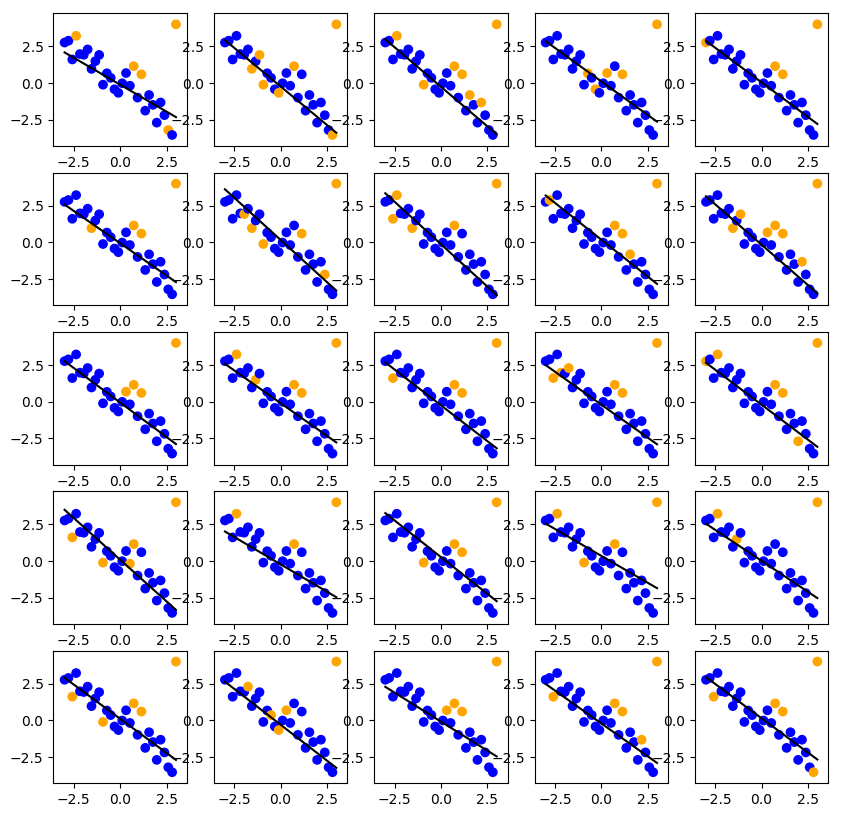

In [46]:
function propose_and_compute_score(xs::Array{Float64,1}, ys::Array{Float64,1},
                                   ransac_params::RansacParams, proposal::Function, proposal_std::Float64)

    # run the proposal program
    proposal_trace = Trace()

    rand_vars = vcat(["slope", "intercept"], ["o$i" for i=1:length(xs)])
    
     for (i,v) in enumerate(rand_vars)
        propose!(proposal_trace, v)
    end
    
    @generate(proposal_trace, proposal(xs, ys, ransac_params, proposal_std))

    # set constraints in the model trace
    model_trace = Trace()
    
    for(i, y) in enumerate(ys)
        constrain!(model_trace, "y$i", y)
    end
    
    for (i,v) in enumerate(rand_vars)
        constrain!(model_trace, v, value(proposal_trace, v))
    end
    
    # run the model program to compute the model score
    @generate(model_trace, linear_regression_outliers(xs))

    # return model trace and score
    proposal_score = score(model_trace) - score(proposal_trace)
    (model_trace, proposal_score)
end

function linreg_infer_sir(num_samples::Int, xs::Array{Float64,1}, 
                          ys::Array{Float64,1}, proposal::Function, proposal_std::Float64, )
    # parameters of proposal
    ransac_params = RansacParams(10, 2, 1.)
    log_weights = Array{Float64,1}(num_samples)
    traces = Array{Trace,1}(num_samples)
    for sample=1:num_samples
        trace, score = propose_and_compute_score(xs, ys, ransac_params, proposal, proposal_std)
        traces[sample] = trace
        log_weights[sample] = score
    end
    weights = exp(log_weights - logsumexp(log_weights))
    chosen = rand(Distributions.Categorical(weights))
    return traces[chosen]
end

# Runs any of the inference algorithms with the number of samples as a parameter
function demo(xs::Array{Float64,1}, ys::Array{Float64,1}, proposal_std::Float64, num_samples::Int, infer::Function)
    plt[:figure](figsize=(10, 10))
    for i=1:num_samples
        trace = infer(100, xs, ys, ransac_proposal, proposal_std)
        plt[:subplot](5, 5, i)
        render_linreg_trace(trace, xs)
    end
    plt[:savefig]("samples.pdf")

end


num_samples = 25
proposal_noise = .2

demo(xs, ys, proposal_noise, num_samples, linreg_infer_sir)

## 6. Effect of proposal output noise on convergence.

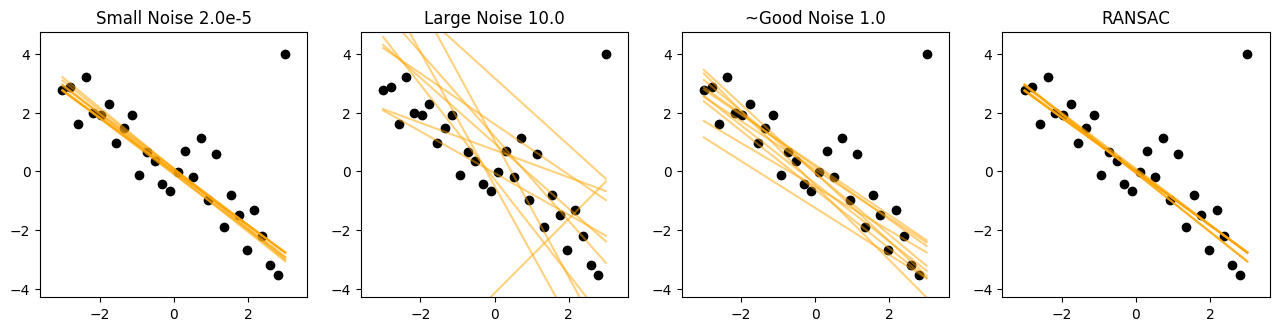

In [47]:
# Run inference an unbounded number of times and collects the traces
function run_inference(xs::Array{Float64,1}, ys::Array{Float64,1}, proposal::Function, proposal_std::Float64, num_samples::Int)
    traces = []
    for i=1:num_samples
        trace = linreg_infer_sir(100, xs, ys, proposal, proposal_std)
        push!(traces, trace)
    end
    traces
end

# Run RANSAC with an unbounded number of iterations. Store as traces and return them
function run_ransac(xs::Array{Float64,1}, ys::Array{Float64,1}, num_samples::Int, ransac::Function)
    traces = []
    for i=1:num_samples
        ransac_params = RansacParams(1000, 2, 1)
        slope, intercept, inliers = ransac(xs, ys, ransac_params)
        
        trace = Trace()
        constrain!(trace, "slope", slope)
        constrain!(trace, "intercept", intercept)
        push!(traces, trace)
    end
    traces
end

# Plots data from a list of traces into a single plot
function plot_many(xs::Array{Float64,1}, ys::Array{Float64,1}, traces::Array{Any, 1}, i::Int, alpha::Float64)
    plt[:subplot](5, 5, i)
    ax = plt[:gca]()
    n = length(xs)
    xmin, xmax = minimum(xs), maximum(xs)
    xspan = xmax - xmin
    ymin, ymax = minimum(ys), maximum(ys)
    yspan = ymax - ymin
    xlim = [xmin - 0.1 * xspan, xmax + 0.1 * xspan]
    ylim = [ymin - 0.1 * yspan, ymax + 0.1 * yspan]
    
    plt[:scatter](xs, ys, c="black")
    for (i, trace) in enumerate(traces)
        intercept = value(trace, "intercept")
        slope = value(trace, "slope")
        xs_line = [xmin, xmax]
        ys_line = intercept + slope * [xmin, xmax]
        plt[:plot](xs_line, ys_line, color="orange", alpha=alpha)
    end
    
    
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
    #ax[:fill_between](xs_line, 2, 0)
end

num_samples = 10

#----- INFERENCE WITH DIFFERENT NOISE--
sm_prop_noise = .00002
traces_sm = run_inference(xs, ys, ransac_proposal, sm_prop_noise, num_samples)
lg_prop_noise = 10.
traces_lg = run_inference(xs, ys, ransac_proposal, lg_prop_noise, num_samples)
nm_prop_noise = 1.
traces_reg = run_inference(xs, ys, ransac_proposal, nm_prop_noise, num_samples)

#----- RANSAC BY ITSELF ----------
traces_ransac = run_ransac(xs, ys, num_samples, ransac_core)


# PLOT THE DIFFERENCES
titles = ["Small Noise $sm_prop_noise", "Large Noise $lg_prop_noise", "~Good Noise $nm_prop_noise", "RANSAC"]
trace_list = [traces_sm, traces_lg, traces_reg, traces_ransac]
plt[:figure](figsize=(20, 20))
for i=1:4
    plot_many(xs, ys, trace_list[i], i, .5)
    plt[:title](titles[i])
end

## 7. Inference with a Buggy Proposal Program

There are some benefits of using inference rather than just an algorithm like RANSAC alone. Let's say that our proposal algorithm has a bug in it (it doesn't work as expected), but it does give a proposal

Below we show a ransac algorithm with a bug. Can you find it? On lines 34 - 40, we entered a comment showing the bug. We removed the line of code that sets `best_num_inliers` to the largest value. Instead it always remains as `-1`. This means that every sample becomes the new line. **We never find the parameter with the most inliers!** It's as if we asked ransac to run only once instead of 10 times!



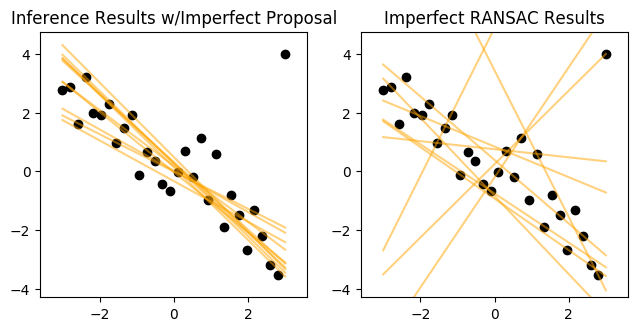

In [48]:
function imperfect_ransac_core(xs::Array{Float64,1}, ys::Array{Float64,1},
                     params::RansacParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    best_inliers = Array{Bool,1}(length(xs))
    for i=1:params.iters

        # select a random subset of points
        ### subset = randperm(length(xs))[1:params.subset_size]
        
        rand_ind = sample(1:length(xs), params.subset_size, replace = false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
    
        ### A = hcat(xs, ones(length(xs)))
        A = hcat(subset_xs, ones(length(subset_xs)))
        
        ### slope, intercept = A\ys
        slope, intercept = A\subset_ys
        
        ypred = intercept + slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_inliers = inliers
            
            # --------BUG--------------
            # HERE we never actually reset 
            # best_num_inliers... 
            # therefore it's always -1.
            #---------------------------
            
            #best_num_inliers = num_inliers <----- BUG
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept, best_inliers)
end

#Overriding the ransac_proposal program with imperfect proposal
@program imperfect_ransac_proposal(xs::Array{Float64,1},
                         ys::Array{Float64,1},
                         ransac_params::RansacParams, 
                         proposal_std::Float64) begin

    # use IMPERFECT RANSAC to guess the line parameters
    slope, intercept, inliers = imperfect_ransac_core(xs, ys, ransac_params)

    # add noise to the line parameters
    slope_proposed = normal(slope, proposal_std) ~ "slope"
    intercept_proposed = normal(intercept, proposal_std) ~ "intercept"

    # add some noise to the proposed outlier statuses
    for i=1:length(xs)
        prob_outlier = inliers[i] ? 0.1 : 0.9
        flip(prob_outlier) ~ "o$i"
    end
end

num_samples = 10

#----- INFERENCE WITH DIFF NOISE--
proposal_noise = 1.
traces_reg = run_inference(xs, ys, imperfect_ransac_proposal, proposal_noise, num_samples)

#----- RANSAC BY ITSELF ----------
traces_ransac = run_ransac(xs, ys, num_samples, imperfect_ransac_core)
#----------------------------------

# PLOT THE DIFFERENCES
titles = ["Inference Results w/Imperfect Proposal", "Imperfect RANSAC Results"]
trace_list = [traces_reg, traces_ransac]
plt[:figure](figsize=(20, 20))
for i=1:2
    plot_many(xs, ys, trace_list[i], i, .5)
    plt[:title](titles[i])
end

### 7.1 Observations on Buggy Proposal

Even when the propoposal program uses a buggy implementation of RANSAC the SIR algorithm retains its asymptotic convergence properties, and gives reasonable results.

## 8. Comparisons

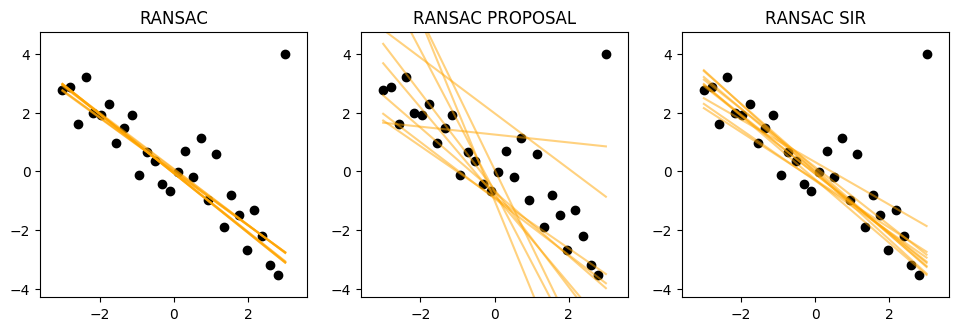

In [49]:
num_samples = 10

#----- RANSAC BY ITSELF ----------
traces_ransac = run_ransac(xs, ys, num_samples, ransac_core)

#----- RANSAC PROPOSAL--------------
traces_proposal = run_ransac_proposal(xs, ys, num_samples, ransac_core)

#----- INFERENCE WITH DIFF NOISE--
proposal_noise = 1.
traces_inference = run_inference(xs, ys, ransac_proposal, proposal_noise, num_samples)


# PLOT THE DIFFERENCES
titles = ["RANSAC", "RANSAC PROPOSAL", "RANSAC SIR"]
trace_list = [traces_ransac, traces_proposal, traces_inference]
plt[:figure](figsize=(20, 20))
for i=1:3
    plot_many(xs, ys, trace_list[i], i, .5)
    plt[:title](titles[i])
end

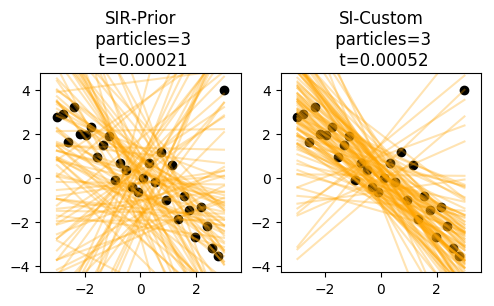

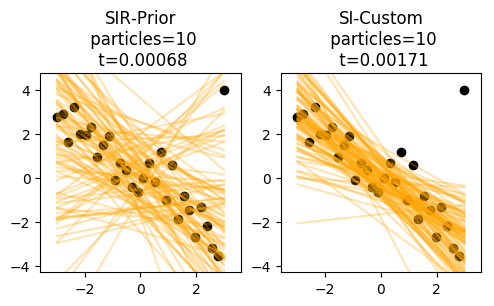

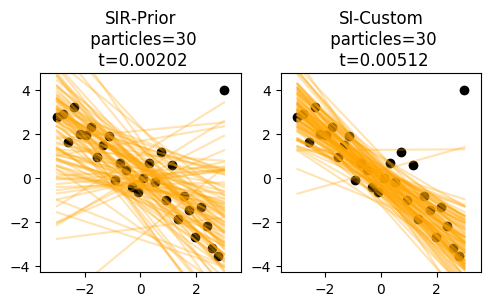

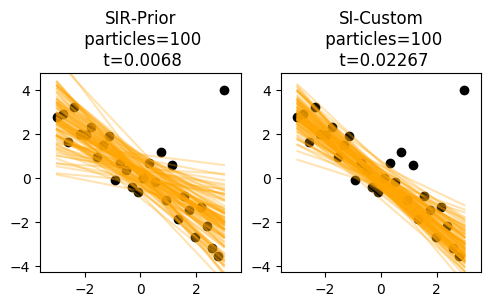

In [50]:
function median(lst)
    lst = sort!(lst)
    n = length(lst)
    if n < 1
        -1
    end
    
    if n % 2 == 1
        lst[Int(floor(n/2)+1)]
    else
        sum(lst[Int(n/2):Int(n/2)+1])/2
    end
end

proposal_std = 1.
sample_list = [3, 10, 30, 100]
prior_med_list = []
custom_med_list = []

for row=1:length(sample_list)
    prior_traces = []
    custom_traces = []

    prior_times = []
    custom_times = []
    num_samples = sample_list[row]
    for replicate=1:100
        tic()
        trace = linear_regression_likelihood_weighting(num_samples, xs, ys)
        elaspsed = toq();

        push!(prior_traces, trace)
        push!(prior_times, elaspsed)

        tic()
        trace = linreg_infer_sir(num_samples, xs, ys, ransac_proposal, proposal_std)
        elaspsed = toq()

        push!(custom_traces, trace)
        push!(custom_times, elaspsed)
    end
    
    # PLOT THE DIFFERENCES
    med_prior = round(median(prior_times),5)
    med_custom = round(median(custom_times),5)
    
    push!(prior_med_list, med_prior)
    push!(custom_med_list, med_custom)
    titles = ["SIR-Prior\n particles=$num_samples\n t=$med_prior", "SI-Custom\n particles=$num_samples\n t=$med_custom"]
    trace_list = [prior_traces, custom_traces]
    plt[:figure](figsize=(15, 15))
    for i=1:2
        plot_many(xs, ys, trace_list[i], i, 0.3)
        plt[:title](titles[i])
    end
end



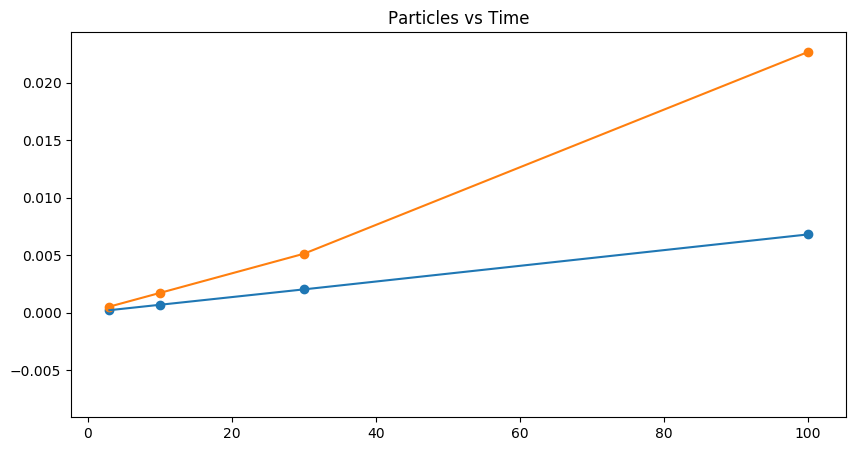

PyObject <matplotlib.text.Text object at 0x32c743910>

In [51]:
plt[:figure](figsize=(10, 5))
plt[:scatter](sample_list, prior_med_list);
plt[:scatter](sample_list, custom_med_list);
plt[:plot](sample_list, prior_med_list);
plt[:plot](sample_list, custom_med_list);
plt[:title]("Particles vs Time")

# SIR with Prior Proposals Module

In [81]:
abstract Module

function constrain_chosen_trace(output::Trace)
    chosen_trace = Trace()
    constrain!(chosen_trace, "slope", value(output, "slope"))
    constrain!(chosen_trace, "intercept", value(output, "intercept"))
    for (j, y) in enumerate(ys)
        constrain!(chosen_trace, "y$j", y)
    end
    chosen_trace
end

immutable SIR <: Gen.Module{Trace}
end

function regenerate(::SIR, output::Trace,
                    xs::Vector{Float64}, ys::Vector{Float64},
                    num_particles::Int)::Float64
    if length(xs) != length(ys)
        error("length o fxs and length of ys do not match")
    end
    particles = Vector{Trace}(num_particles)
    scores = Vector{Float64}(num_particles)
    
    # pick a random index from 1..num_particles
    chosen = rand(Categorical(num_particles)) 
    particles[chosen] = output
    
    # Constrain chosen trace and run generative model to get score 
    chosen_trace = constrain_chosen_trace(output)
    @generate(chosen_trace, linear_regression_outliers(xs))
    scores[chosen] = score(chosen_trace)

    # sample the other particles from the importance distribution
    for i=1:num_particles
        if i == chosen
            continue
        end
        trace = Trace()
        for (j, y) in enumerate(ys)
            constrain!(trace, "y$j", y)
        end
        @generate(trace, linear_regression_outliers(xs))
        particles[i] = trace
        scores[i] = score(trace)
    end

    # compute the module's log_weight
    weights = exp(scores - logsumexp(scores))
    
    # p(u, x) / q(u; x) = pi(x, y) / mean(weights)
    return score(chosen_trace) - (logsumexp(weights) - log(num_particles))
end

function sim_likelihood(particles::Vector{Trace}, scores::Vector{Float64})::Tuple{Trace, Float64}
    weights = exp(scores - logsumexp(scores))
    chosen = rand(Categorical(weights))
    chosen_trace = particles[chosen]

    # p(u, x) / q(u; x) = pi(x, y) / mean(weights)
    chosen_score = score(chosen_trace) - (logsumexp(scores) - log(length(particles)))
    return (chosen_trace, chosen_score)
end

function simulate(::SIR, xs::Vector{Float64}, ys::Vector{Float64},
                    num_particles::Int)::Tuple{Trace, Float64}
    particles = Vector{Trace}(num_particles)
    scores = Vector{Float64}(num_particles)
    for i=1:num_particles
        trace = Trace()
        for (j, y) in enumerate(ys)
            constrain!(trace, "y$j", y)
        end
        @generate(trace, linear_regression_outliers(xs))
        particles[i] = trace
        scores[i] = score(trace)
    end
    
    return sim_likelihood(particles, scores)
end

# now that we have the module, we can do:

# 1. use it as a primitive in a probabilistic program:

# a = sir(xs, ys, num_particle) ~ "output"

# 2. implement AIDE for it

# ---------------------------------------------------------


simulate (generic function with 2 methods)

In [82]:
output, likelihood = simulate(SIR(), xs, ys, 100)
regenerate(SIR(), output, xs, ys, 100)

-64.61279676596475

In [97]:
function constrain_for_proposal(output::Trace, n::Int)
    chosen_trace = Trace()
    constrain!(chosen_trace, "slope", value(output, "slope"))
    constrain!(chosen_trace, "intercept", value(output, "intercept"))
    
    outlier_statuses = map((i) -> value(output,"o$i"), 1:n)
    for (j, o) in enumerate(outlier_statuses)
        constrain!(chosen_trace, "o$j", o)
    end
    chosen_trace
end

immutable CustomSIR <: Gen.Module{}
end

function regenerate(::CustomSIR, output::Trace,
                    xs::Vector{Float64}, ys::Vector{Float64},
                    num_particles::Int)::Float64
    if length(xs) != length(ys)
        error("length o fxs and length of ys do not match")
    end
    
    particles = Vector{Trace}(num_particles)
    scores = Vector{Float64}(num_particles)

    proposal_trace = constrain_for_proposal(output, length(xs))
    @generate(proposal_trace, ransac_proposal(xs, ys, RansacParams(10, 2, 1.), 1.))
    
    chosen_trace = constrain_chosen_trace(output)
    @generate(chosen_trace, linear_regression_outliers(xs))
    
    chosen_score = score(chosen_trace) - score(proposal_trace)
    
    # pick a random index from 1..num_particles
    chosen = rand(Categorical(num_particles)) 
    particles[chosen] = output
    scores[chosen] = chosen_score 

    # TODO: missing GEN abstraction,should have these programs to be written more generally 
    # sample the other particles from the importance distribution
    for i=1:num_particles
        if i == chosen
            continue
        end
        trace, score = propose_and_compute_score(xs, ys, RansacParams(10, 2, 1.), ransac_proposal, 1.)
        particles[i] = trace
        scores[i] = score 
    end

    # compute the module's log_weight
    weights = exp(scores - logsumexp(scores))

    # p(u, x) / q(u; x) = pi(x, y) / mean(weights)
    return score(chosen_trace) - (logsumexp(weights) - log(num_particles))
end

function simulate(::CustomSIR, xs::Vector{Float64}, ys::Vector{Float64},
                    num_particles::Int)::Tuple{Trace, Float64}
    particles = Vector{Trace}(num_particles)
    scores = Vector{Float64}(num_particles)
    for i=1:num_particles
        trace = Trace()
        for (j, y) in enumerate(ys)
            constrain!(trace, "y$j", y)
        end
        trace, score = propose_and_compute_score(xs, ys, RansacParams(10, 2, 1.), ransac_proposal, 1.)
        particles[i] = trace
        scores[i] = score 
    end
    return sim_likelihood(particles, scores)
end

simulate (generic function with 2 methods)

In [101]:
output, likelihood = simulate(CustomSIR(), xs, ys, 100)
regenerate(CustomSIR(), output, xs, ys, 100)

-57.33375690445409

In [140]:
# TODO
# estimates the generalized ELBO L_{pq} 
function estimate_elbo(p::Gen.Module, q::Gen.Module, KP::Int, KQ::Int, xs::Vector{Float64}, ys::Vector{Float64},
                    p_num_particles::Int, q_num_particles::Int)
    p_log_weights = Array{Float64,1}(KP)
    q_log_weights = Array{Float64,1}(KQ)
    
    output, p_log_weights[1] = simulate(p, xs, ys, p_num_particles)
    
    for k=2:KP
        p_log_weights[k] = regenerate(p, output, xs, ys, p_num_particles)
    end
    for k=1:KQ
        q_log_weights[k] = regenerate(q, output, xs, ys, q_num_particles)
    end
    ((logsumexp(q_log_weights) - log(KQ)) -
     (logsumexp(p_log_weights) - log(KP)))
end

function estimate_elbo_par(p::Gen.Module, q::Gen.Module, KP::Int, KQ::Int, xs::Vector{Float64}, ys::Vector{Float64},
                   p_num_particles::Int, q_num_particles::Int, N::Int)
    f = (i::Int) -> estimate_elbo(p, q, KP, KQ, xs, ys, p_num_particles, q_num_particles)
    estimates::Array{Float64,1} = map(f, 1:N) #pmap for parallizing
    estimates
end

estimate_elbo_par (generic function with 2 methods)

In [141]:
p = SIR()
q = CustomSIR()

p_num_particles = 1000

symkl_estimates = []

for i=1:100
    q_num_particles = i
    lowers = estimate_elbo_par(p, q, 1, 1, xs, ys, p_num_particles, q_num_particles, 5)
    uppers = -estimate_elbo_par(q, p, 1, 1, xs, ys, q_num_particles, p_num_particles, 5)
    push!(symkl_estimates, mean(uppers) - mean(lowers))
end



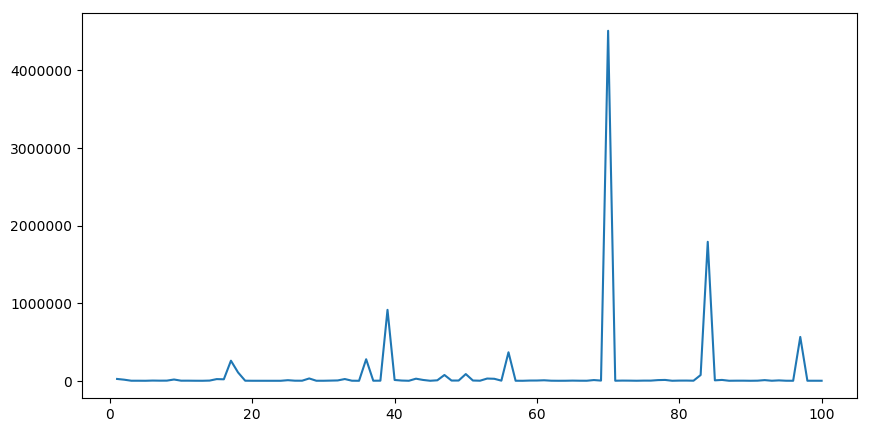

Any[23735.6,14173.5,838.323,838.782,354.067,2959.16,1623.39,2090.5,16506.8,1345.31,1483.06,591.427,320.026,2633.34,21730.1,19168.2,2.58686e5,1.07412e5,1140.28,370.099,254.74,220.871,201.957,176.955,7787.92,1244.23,1088.21,30129.7,659.545,531.131,2447.99,4447.35,22553.9,993.484,187.101,2.77492e5,1102.68,1481.18,9.1385e5,10500.8,3068.2,295.981,27043.3,10911.4,416.249,6320.96,74767.6,3029.6,3291.36,86620.2,3557.92,1049.64,28846.8,25915.9,1802.41,3.67139e5,686.415,202.247,3067.3,3452.21,6620.66,1182.22,305.554,678.875,2366.66,988.442,691.609,9451.11,2727.92,4.50813e6,860.276,2565.69,1970.02,609.217,2385.89,2244.27,8825.47,11059.3,420.433,2483.45,2788.51,1189.93,74124.1,1.79019e6,5843.67,11125.6,489.433,1445.71,1570.33,339.641,1565.1,8649.9,649.812,5261.02,764.337,363.401,5.6473e5,682.971,691.227,513.338]

In [142]:
plt[:figure](figsize=(10, 5))
plt[:plot](collect(1:100), symkl_estimates);

print(symkl_estimates)